# Healthcare Accessibility Across Ontario

## Project Overview
This project aims to analyze healthcare accessibility across different regions in Ontario by visualizing the distribution and density of healthcare facilities in relation to the population. This allows us to identify areas with potentially insufficient healthcare services.

## Contributors
- Benjamin Strain- 210468300
- Cagri Isilak- 210764050
- Ethan Farrar- 211504510

##### Professor: Jiashu Zhao  

## Data Sources
- **Hospital Locations**: Extracted from Ontario's open data portal. This dataset includes information on the names, types, and locations of healthcare facilities in Ontario.
  - Data URL: [Ontario Hospital Locations](https://data.ontario.ca/dataset/hospital-locations)
- **Population Data**: Provides population statistics for municipalities in Ontario, essential for per capita calculations.
  - Data URL: [Ontario Population and Dwelling Counts](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=9810000202)


In [254]:
! pip install pandas geopandas matplotlib seaborn shapely geopy tqdm adjustText wget


In [255]:
# Import necessary libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import seaborn as sns
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from tqdm import tqdm
import matplotlib.colors as colors
from adjustText import adjust_text
import numpy as np
import requests


tqdm.pandas()

## Download Data from Github Repository
- https://github.com/notoctosting/Healthcare_Accessibility_Project_CP321

### Fetch and Download the Population Data:

In [256]:
# URL of the Population and Dwelling Counts dataset
file_url = 'https://raw.githubusercontent.com/notoctosting/Healthcare_Accessibility_Project_CP321/main/datasets/Ontario_Population_and_Dwelling_Counts.csv'
# Send a GET request to the file URL
response = requests.get(file_url)

# Check if the request was successful
if response.status_code == 200:
    # Open the file in binary write mode and save the content to the local file
    with open('Ontario_Population_and_Dwelling_Counts.csv', 'wb') as file:
        file.write(response.content)
    print('File downloaded successfully')    
else:
    print('Failed to retrieve the file')

File downloaded successfully


### Fetch and Download the Hospital Data:

In [257]:
# URL of the Hospitals dataset
file_url = 'https://raw.githubusercontent.com/notoctosting/Healthcare_Accessibility_Project_CP321/main/datasets/Ontario_Hospital_Locations.csv'
# Send a GET request to the file URL
response = requests.get(file_url)

# Check if the request was successful
if response.status_code == 200:
    # Open the file in binary write mode and save the content to the local file
    with open('Ontario_Hospital_Locations.csv', 'wb') as file:
        file.write(response.content)
    print('File downloaded successfully')    
else:
    print('Failed to retrieve the file')

File downloaded successfully


### Fetch and Download the GeoLocation Data:

In [258]:
# URL of the GeoLocation dataset
file_url = 'https://raw.githubusercontent.com/notoctosting/Healthcare_Accessibility_Project_CP321/main/datasets/merged_data_with_location.csv'
# Send a GET request to the file URL
response = requests.get(file_url)

# Check if the request was successful
if response.status_code == 200:
    # Open the file in binary write mode and save the content to the local file
    with open('merged_data_with_location.csv', 'wb') as file:
        file.write(response.content)
    print('File downloaded successfully')    
else:
    print('Failed to retrieve the file')

File downloaded successfully


In [259]:
# Load the population data into a DataFrame
population_df = pd.read_csv('Ontario_Population_and_Dwelling_Counts.csv')

# Load the hospital locations data into a DataFrame
hospital_df = pd.read_csv('Ontario_Hospital_Locations.csv')



### Fetch and Download the Shapefile Layers for Ontario Chloropleth Map:

In [260]:
# URL of the base map shapefile
file_url = 'https://raw.githubusercontent.com/notoctosting/Healthcare_Accessibility_Project_CP321/main/datasets/ontario_shapefiles/base_map/OBM_INDEX.shp'
# Send a GET request to the file URL
response = requests.get(file_url)

# Check if the request was successful
if response.status_code == 200:
    # Open the file in binary write mode and save the content to the local file
    with open('OBM_INDEX.shp', 'wb') as file:
        file.write(response.content)
    print('File downloaded successfully')    
else:
    print('Failed to retrieve the file')

#  URL of the upper tier boundaries shapefile
file_url = 'https://raw.githubusercontent.com/notoctosting/Healthcare_Accessibility_Project_CP321/main/datasets/ontario_shapefiles/upper_tier_boundaries/Municipal_Boundary_-_Upper_Tier_and_District.shp'
# Send a GET request to the file URL
response = requests.get(file_url)

# Check if the request was successful
if response.status_code == 200:
    # Open the file in binary write mode and save the content to the local file
    with open('_Upper_Tier_and_District.shp', 'wb') as file:
        file.write(response.content)
    print('File downloaded successfully')    
else:
    print('Failed to retrieve the file')

# URL of the geographic names shapefile
file_url = 'https://raw.githubusercontent.com/notoctosting/Healthcare_Accessibility_Project_CP321/main/datasets/ontario_shapefiles/names/Geographic_Names_Ontario.shp'
# Send a GET request to the file URL
response = requests.get(file_url)

# Check if the request was successful
if response.status_code == 200:
    # Open the file in binary write mode and save the content to the local file
    with open('Geographic_Names_Ontario.shp', 'wb') as file:
        file.write(response.content)
    print('File downloaded successfully')    
else:
    print('Failed to retrieve the file')

# URL of the Township shapefile
file_url = 'https://raw.githubusercontent.com/notoctosting/Healthcare_Accessibility_Project_CP321/main/datasets/ontario_shapefiles/township/Geographic_Township_Improved.shp'
# Send a GET request to the file URL
response = requests.get(file_url)

# Check if the request was successful
if response.status_code == 200:
    # Open the file in binary write mode and save the content to the local file
    with open('Geographic_Township_Improved.csv', 'wb') as file:
        file.write(response.content)
    print('File downloaded successfully')    
else:
    print('Failed to retrieve the file')

File downloaded successfully
File downloaded successfully
File downloaded successfully
File downloaded successfully


## Data Processing

The data is cleaned and merged to create a comprehensive dataset that includes the number of facilities per capita for each community. The cleaning process involves converting textual numeric values to actual numbers and dealing with any missing or duplicate data.

- `clean_population_data()`: Removes unnecessary commas from numeric values and handles non-numeric data.

In [261]:
def clean_population_data(data):
    """Clean the population data and return the cleaned data.
    
    Args:
        data: A pandas DataFrame containing the population data.
    
    Returns:
        A pandas DataFrame containing the cleaned population data."""
    numeric_columns = [
        "Population, 2021", "Population, 2016",
        "Total private dwellings, 2021", "Total private dwellings, 2016",
        "Private dwellings occupied by usual residents, 2021", "Private dwellings occupied by usual residents, 2016"
    ]
    for column in numeric_columns:
        if data[column].dtype == 'object':
            # Remove commas and convert to numeric
            data[column] = pd.to_numeric(data[column].str.replace(',', ''), errors='coerce')
    data = data[['Geographic name', 'Population, 2021']].dropna()
    data['Geographic name'] = data['Geographic name'].str.title()
    return data

- `load_population_data()`: Loads and cleans population data from a CSV file.


In [262]:
def load_population_data(filepath="datasets/Ontario_Population_and_Dwelling_Counts.csv"):
    """Load the population data from the specified file and return it as a pandas DataFrame.

    Args:
        filepath: A string containing the path to the file to load.

    Returns:
        A pandas DataFrame containing the population data."""
    
    column_names = [
        "Geographic name", "Geographic area type abbreviation", "Population, 2021", "Population, 2016",
        "Population percentage change, 2016 to 2021", "Total private dwellings, 2021",
        "Total private dwellings, 2016", "Total private dwellings percentage change, 2016 to 2021",
        "Private dwellings occupied by usual residents, 2021", "Private dwellings occupied by usual residents, 2016",
        "Private dwellings occupied by usual residents percentage change, 2016 to 2021",
        "Land area in square kilometres, 2021", "Population density per square kilometre, 2021",
        "National population rank, 2021", "Province/territory population rank, 2021"
    ]
    population_data = pd.read_csv(filepath, names=column_names, header=0)
    population_data = clean_population_data(population_data)
    return population_data

- `clean_hospital_data()`: Processes hospital data to remove duplicates and unnecessary information.


In [263]:
def clean_hospital_data(data):
    """Clean the hospital data and return the cleaned data.

    Args:
        data: A pandas DataFrame containing the hospital data.

    Returns:
        A pandas DataFrame containing the cleaned hospital data."""
    data = data[['ENGLISH_NA', 'COMMUNITY', 'ADDRESS_LI', 'POSTAL_COD']]
    data['COMMUNITY'] = data['COMMUNITY'].str.title()
    data['Facility_Name'] = data['ENGLISH_NA'].apply(lambda x: x.split('-')[0].strip())
    data = data.drop_duplicates(subset=['Facility_Name'])
    return data

- `load_hospital_data()`: Loads and cleans hospital location data from a CSV file.


In [264]:
def load_hospital_data(filepath="datasets/Ontario_Hospital_Locations.csv"):
    """Load the hospital data from the specified file and return it as a pandas DataFrame.

    Args:
        filepath: A string containing the path to the file to load.

    Returns:
        A pandas DataFrame containing the hospital data."""
    
    hospital_data = pd.read_csv(filepath)
    hospital_data = clean_hospital_data(hospital_data)
    return hospital_data

- `merge_datasets()`: Merges population and hospital data on the community name.


In [265]:
def merge_datasets(hospital_data, population_data):
    """Merge the hospital and population datasets and return the merged data.
    
    Args:
        hospital_data: A pandas DataFrame containing the hospital data.
        population_data: A pandas DataFrame containing the population data.
        
    Returns:
        A pandas DataFrame containing the merged data."""
    
    # Preprocessing steps if any additional are needed
    population_data['Geographic name'] = population_data['Geographic name'].str.title()
    hospital_data['COMMUNITY'] = hospital_data['COMMUNITY'].str.title()
    # Merge the data on the community name
    merged_data = pd.merge(hospital_data, population_data, left_on='COMMUNITY', right_on='Geographic name', how='inner')
    merged_data.dropna(subset=['Population, 2021'], inplace=True)
    merged_data.drop(columns=['Geographic name'], inplace=True)
    return merged_data

 - Optional - Initiate Geopy API to fetch Coordinates of Addresses

In [266]:
# Initialize the geolocator
geolocator = Nominatim(user_agent="geoapiExercises")
# To prevent spamming the service with too many requests, use RateLimiter
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

- `fetch_geopy_coordinates()`: (Optional) Fetches geographical coordinates for each hospital location. This is typically pre-processed due to long run times.


In [267]:
# function to get the coordinates from the address using geopy api - takes around 2.5 hours to run so use pre-collected data if possible
def fetch_geopy_coordinates(merged_data):
    """Fetch the coordinates for the hospital addresses using the geopy API.    
    Args:
        merged_data: A pandas DataFrame containing the merged hospital and population data. 
    Returns:
        A GeoDataFrame containing the hospital data with point geometry."""
    
    # Define a function to parse the location into point geometry
    def geocode_address(address):
        """ Geocode the address and return the point geometry.
        Args:
            address: A string containing the address to geocode.
        Returns:
            A Point geometry if the address was successfully geocoded, None otherwise."""
        try:
            location = geocode(address)
            if location:
                return Point(location.longitude, location.latitude)
        except Exception as e:
            print(f"Error geocoding address {address}: {e}")
        return None
    # Apply geocoding to the address column
    merged_data['address'] = merged_data['ADDRESS_LI'] + ', ' + merged_data['COMMUNITY'] + ', Ontario, Canada'
    merged_data['point'] = merged_data['address'].head(10).progress_apply(geocode_address)
    # Drop rows where geocoding failed
    merged_data = merged_data.dropna(subset=['point'])
    # Convert the DataFrame to a GeoDataFrame
    hospital_gdf = gpd.GeoDataFrame(merged_data, geometry='point')
    # Save the data to a CSV file including longitude and latitude
    hospital_gdf['latitude'] = hospital_gdf.geometry.y
    hospital_gdf['longitude'] = hospital_gdf.geometry.x
    hospital_gdf.to_csv("datasets/merged_data_with_locations_v2.csv", index=False)
    return hospital_gdf

- Optional - to use geopy api to collect coordinates of each address:

In [268]:
# # run the api to get the coordinates of the hospitals - takes around 2.5 hours to run so use pre-collected data if possible
# hospital_gdf = fetch_geopy_coordinates(merged_data)

- `load_precollected_data()`: Loads previously fetched geographical coordinates.


In [269]:
def load_precollected_data(filepath = "datasets/merged_data_with_location.csv"):
    """Load the pre-collected hospital data with coordinates and return it as a GeoDataFrame.

    Args:
        filepath: A string containing the path to the file to load.

    Returns:
        A GeoDataFrame containing the hospital data with point geometry."""
    data = pd.read_csv(filepath)
    # Ensure columns containing longitude and latitude are correctly typed
    data['latitude'] = pd.to_numeric(data['latitude'], errors='coerce')
    data['longitude'] = pd.to_numeric(data['longitude'], errors='coerce')
    data.dropna(subset=['latitude', 'longitude'], inplace=True)
    gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude))
    gdf.set_crs(epsg=4326, inplace=True)
    return gdf

- `load_geonames_data()`: Loads geographical names data for Ontario.


In [270]:
def load_geonames_data(filepath):
    """ Load the GeoNames data from the specified file and return it as a GeoDataFrame.
    Args:
        filepath: A string containing the path to the file to load.
    Returns:
        A GeoDataFrame containing the GeoNames data."""
    # Use GeoPandas to read shapefile data
    geonames_data = gpd.read_file(filepath)
    return geonames_data

- `load_and_simplify_shapefile()`: Loads a shapefile and simplifies its geometry using the specified tolerance

In [271]:
def load_and_simplify_shapefile(filepath, tolerance=0.1):
    """ Load a shapefile and simplify its geometry using the specified tolerance.
    
    Args:
        filepath: A string containing the path to the shapefile to load.
        tolerance: A float specifying the tolerance value for simplification.
        
    Returns:
        A GeoDataFrame containing the simplified shapefile data."""
    gdf = gpd.read_file(filepath)
    gdf['geometry'] = gdf['geometry'].simplify(tolerance)
    return gdf

- `normalize_marker_sizes()`: Normalizes marker sizes for the choropleth map.


In [272]:
def normalize_marker_sizes(series, min_size=50, max_size=750):
    """ Normalize the values in a series to be within the specified range.  
    Args:
        series: A pandas Series containing the values to normalize.
        min_size: An integer specifying the minimum size for the markers.
        max_size: An integer specifying the maximum size for the markers.
    Returns:
        A pandas Series containing the normalized values."""
    # Normalize series to have a minimum of min_size and a maximum of max_size
    series_normalized = (series - series.min()) / (series.max() - series.min())
    return series_normalized * (max_size - min_size) + min_size

- `identify_extreme_cities()`: Identifies the communities with the highest and lowest facilities per capita.


In [273]:
# Function to identify highest and lowest facilities per capita
def identify_extreme_cities(merged_data):
    """Identify the city with the highest and lowest facilities per capita.
    
    Args:
        merged_data: A pandas DataFrame containing the merged hospital and population data.
        
    Returns:
        A tuple containing the names of the city with the highest and lowest facilities per capita."""
    # Sort by facilities per capita
    sorted_data = merged_data.sort_values('Facilities_Per_Capita', ascending=False)
    # Get the highest and lowest
    highest = sorted_data.head(1)
    lowest = sorted_data.tail(1)
    # Return their community names
    return highest['COMMUNITY'].values[0], lowest['COMMUNITY'].values[0]

## Data Processing
We begin by loading the population data and cleaning it to ensure accuracy. This includes converting data types and handling missing values.


In [274]:
population_data = load_population_data("Ontario_Population_and_Dwelling_Counts.csv")   
hospital_data = load_hospital_data("Ontario_Hospital_Locations.csv")

C:\Users\ethan\AppData\Local\Temp\ipykernel_32212\3392131015.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['COMMUNITY'] = data['COMMUNITY'].str.title()
C:\Users\ethan\AppData\Local\Temp\ipykernel_32212\3392131015.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Facility_Name'] = data['ENGLISH_NA'].apply(lambda x: x.split('-')[0].strip())


In [275]:
# Group the hospital data by facility name
grouped_hospitals = hospital_data.groupby('Facility_Name').first().reset_index()

# Aggregate the population data by geographic name
aggregated_population = population_data.groupby('Geographic name')['Population, 2021'].sum().reset_index()

In [276]:
# update the population 2021 column data to be the aggregated population so that theres no duplicates for each area type
population_data = population_data.merge(aggregated_population, on='Geographic name', how='inner')
population_data.drop(columns=['Population, 2021_x'], inplace=True)
population_data.rename(columns={'Population, 2021_y': 'Population, 2021'}, inplace=True)

In [277]:
# Merge data on city name
merged_data = merge_datasets(hospital_data, population_data)

# Calculate Facilities Per Capita
merged_data['Facilities_Per_Capita'] = merged_data.groupby('COMMUNITY').transform('count')['Facility_Name'] / merged_data['Population, 2021']
print(merged_data.tail(10))

                                             ENGLISH_NA         COMMUNITY  \
7510                    Huron Hospice Volunteer Service        Huron East   
7511                                      Wahta Mohawks     Muskoka Lakes   
7512        Mississaugas of the New Credit First Nation  Haldimand County   
7513                               Weenusk First Nation         Peawanuck   
7514                             Municipality of Machin            Machin   
7515                             Nipissing First Nation      Nipissing 10   
7516  Chippewas of Kettle and Stony Point Home Suppo...    Lambton Shores   
7517                             Keewaywin First Nation       Kee-Way-Win   
7518                          Henvey Inlet First Nation   French River 13   
7519                                 Residence Lefebvre          Moonbeam   

                   ADDRESS_LI POSTAL_COD  \
7510      24 Centennial Drive     N0K1W0   
7511          Muskoka Road 38     P0C1A0   
7512                

In [278]:
# identify the highest and lowest facilities per capita
highest_FPC, lowest_FPC = identify_extreme_cities(merged_data)
print(f"The city with the highest facilities per capita is {highest_FPC}")
print(f"The city with the lowest facilities per capita is {lowest_FPC}")

The city with the highest facilities per capita is Killarney
The city with the lowest facilities per capita is Haldimand County


Read the geocoded data from the csv file:

In [279]:
# read the geocoded data from the csv file
hospital_gdf = load_precollected_data("datasets/merged_data_with_location.csv")


## Visualizations
We generate a series of visualizations to better understand the accessibility of healthcare facilities in Ontario, including bar charts, scatter plots, and choropleth maps.


### Bar Chart of Facilities Per Capita
*This bar chart displays the number of healthcare facilities relative to the population size for each community, sorted to show communities with the highest and lowest facilities per capita.*

C:\Users\ethan\AppData\Local\Temp\ipykernel_32212\1959755641.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='COMMUNITY', y='Facilities_Per_Capita', data=sorted_data, palette='viridis')


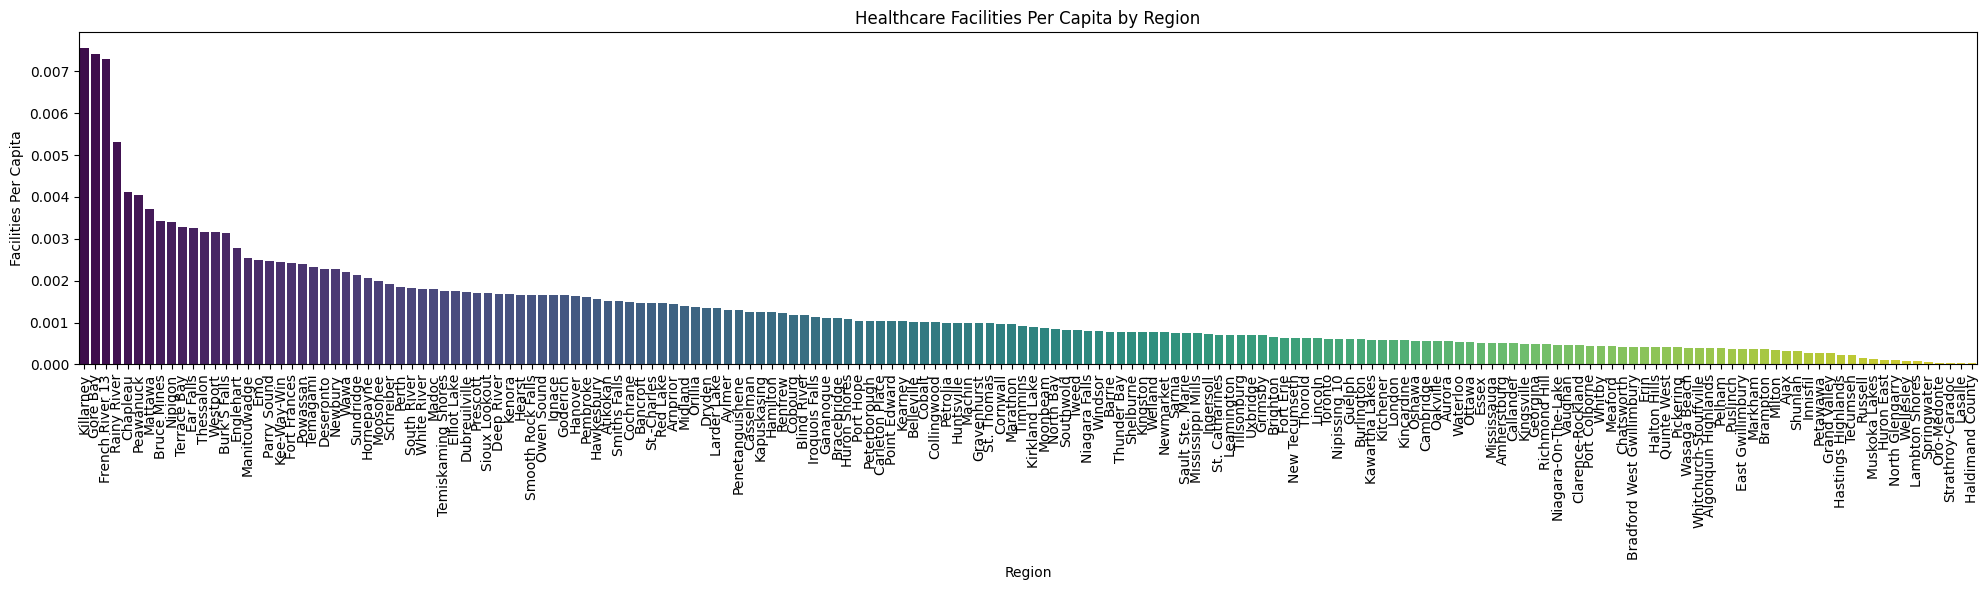

In [280]:
def plot_bar_chart_of_facilities_per_capita(data):
    """
    Plot a bar chart of the number of healthcare facilities per capita by region
    :param data: The merged dataset containing the number of healthcare facilities and population data
    """
    # Sort the data by 'Facilities_Per_Capita' in descending order
    sorted_data = data.sort_values('Facilities_Per_Capita', ascending=False)
    plt.figure(figsize=(20, 6))
    # Ensure that the barplot uses the sorted data
    sns.barplot(x='COMMUNITY', y='Facilities_Per_Capita', data=sorted_data, palette='viridis')
    plt.xticks(rotation=90)
    plt.title('Healthcare Facilities Per Capita by Region')
    plt.xlabel('Region')
    plt.ylabel('Facilities Per Capita')
    plt.tight_layout()
    plt.savefig('datasets/bar_chart_facilities_per_capita_sorted.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_bar_chart_of_facilities_per_capita(merged_data)

##### Analysis: 
- The general trend shown is that there are fewer healthcare facilities per capita in more densely populated areas, and more per capita farther away from the cities. This is proven by the top 3 in the bar chart: Killarney, Gore Bay and French River are all not in any major cities.

### Choropleth Map Visualization
*A geographical map showing the distribution of facilities per capita across Ontario, with annotations for significant regions, and the size of the markers proportional to the population size.*

c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\text.py:753: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\text.py:566: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\text.py:567: FutureWarning: Calling float on a single element

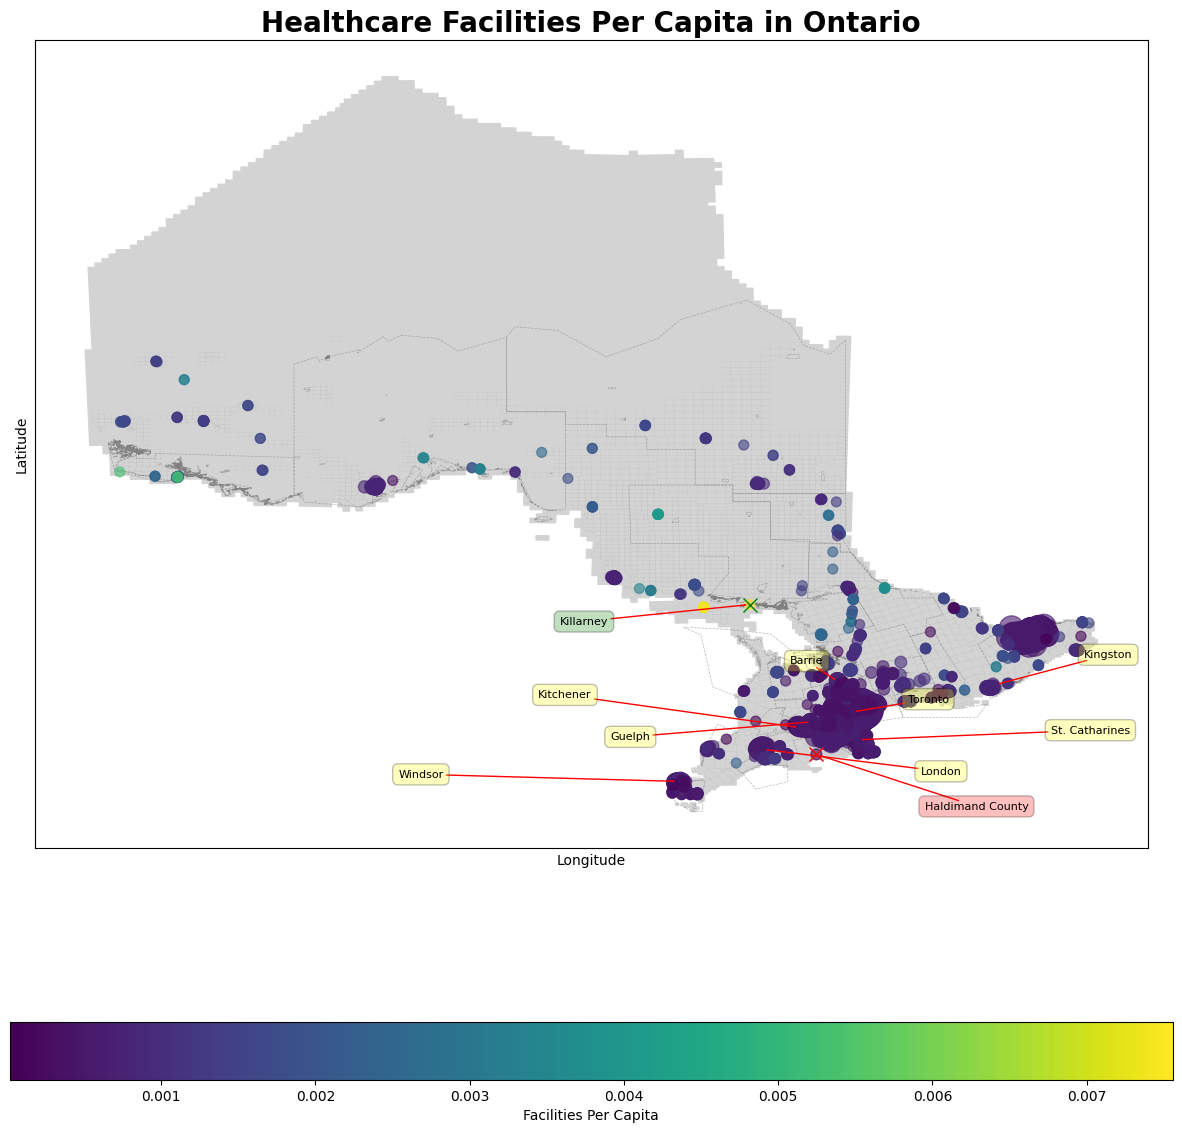

In [281]:
def plot_ontario_map(hospital_gdf, base_map_path, upper_tier_path ,geonames_path,townships_path, highest_FPC, lowest_FPC):
    ontario_map = load_and_simplify_shapefile(base_map_path, tolerance=0.000)
    upper_tier_boundaries = load_and_simplify_shapefile(upper_tier_path, tolerance=0.1)
    geonames_gdf = load_geonames_data(geonames_path)
    townships_gdf = load_and_simplify_shapefile(townships_path, tolerance=0.001)

    # Ensure the coordinate reference systems match
    if ontario_map.crs != hospital_gdf.crs:
        hospital_gdf = hospital_gdf.to_crs(ontario_map.crs)
    if ontario_map.crs != upper_tier_boundaries.crs:
        upper_tier_boundaries = upper_tier_boundaries.to_crs(ontario_map.crs)
    if ontario_map.crs != geonames_gdf.crs:
        geonames_gdf = geonames_gdf.to_crs(ontario_map.crs)

    # Normalize the total population for the marker size
    hospital_gdf['marker_size'] = normalize_marker_sizes(hospital_gdf['Population, 2021'])

    # Start plotting
    fig, ax = plt.subplots(figsize=(15, 15))
    ontario_map.plot(ax=ax, color='lightgrey', edgecolor='lightgrey')
    townships_gdf.plot(ax=ax, edgecolor='grey', linewidth=0.05, alpha=0.5, facecolor="none")
    upper_tier_boundaries.plot(ax=ax, edgecolor='grey', linewidth=0.5, alpha=0.55, linestyle='--', facecolor="none")
    major_cities = ['Toronto', 'Ottawa', 'Hamilton', 'London', 'Kitchener', 'Windsor', 'Barrie', 'Kingston', 'Guelph', 'St. Catharines']
    
    texts = []
    for idx, row in geonames_gdf.iterrows():
        centroid = row['geometry'].centroid
        if row['LABEL'] in major_cities:
            texts.append(ax.text(centroid.x, centroid.y, row['LABEL'], fontsize=8, ha='center', va='center',
                             bbox=dict(facecolor='yellow', alpha=0.25, edgecolor='black', boxstyle='round,pad=0.5')))

    # add the highest and lowest cities to the plot
    highest_city = hospital_gdf[hospital_gdf['COMMUNITY'] == highest_FPC]
    lowest_city = hospital_gdf[hospital_gdf['COMMUNITY'] == lowest_FPC]
    ax.plot(highest_city.geometry.x, highest_city.geometry.y, 'x', color='green', markersize=10)
    ax.plot(lowest_city.geometry.x, lowest_city.geometry.y, 'x', color='red', markersize=10)
    texts.append(ax.text(highest_city.geometry.x, highest_city.geometry.y, highest_FPC, fontsize=8, ha='center', va='center',
                             bbox=dict(facecolor='green', alpha=0.25, edgecolor='black', boxstyle='round,pad=0.5')))
    texts.append(ax.text(lowest_city.geometry.x, lowest_city.geometry.y, lowest_FPC, fontsize=8, ha='center', va='center',
                                bbox=dict(facecolor='red', alpha=0.25, edgecolor='black', boxstyle='round,pad=0.5')))

    hospital_gdf.plot(ax=ax, column='Facilities_Per_Capita', cmap='viridis', alpha=0.6,
                          markersize=hospital_gdf['marker_size'], legend=True,
                          legend_kwds={'label': "Facilities Per Capita", 'orientation': "horizontal"})
    adjust_text(texts, expand=(5, 3.25), # expand text bounding boxes by 1.2 fold in x direction and 2 fold in y direction
                arrowprops=dict(arrowstyle='->', color='red') # ensure the labeling is clear by adding arrows
                )
    ax.set_title('Healthcare Facilities Per Capita in Ontario', fontsize=20, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    # Adjust visual elements
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    plt.show()

plot_ontario_map(hospital_gdf, base_map_path, upper_tier_path, geonames_path, townships_path, highest_FPC, lowest_FPC)

##### Analysis:
- In this simplified map of Ontario, it is very clear that the most populated areas and the biggest cities have the worst access to healthcare facilities, and the colour of the circles depicting the number of facilities per capita only starts to lighten to a greener colour as you get farther from the big cities. In general, the lightest colours can be seen in rural areas nowhere near any town or city. 

### Scatter Plot of Population vs. Facilities Per Capita
*Illustrates the relationship between population size and the number of facilities per capita.*


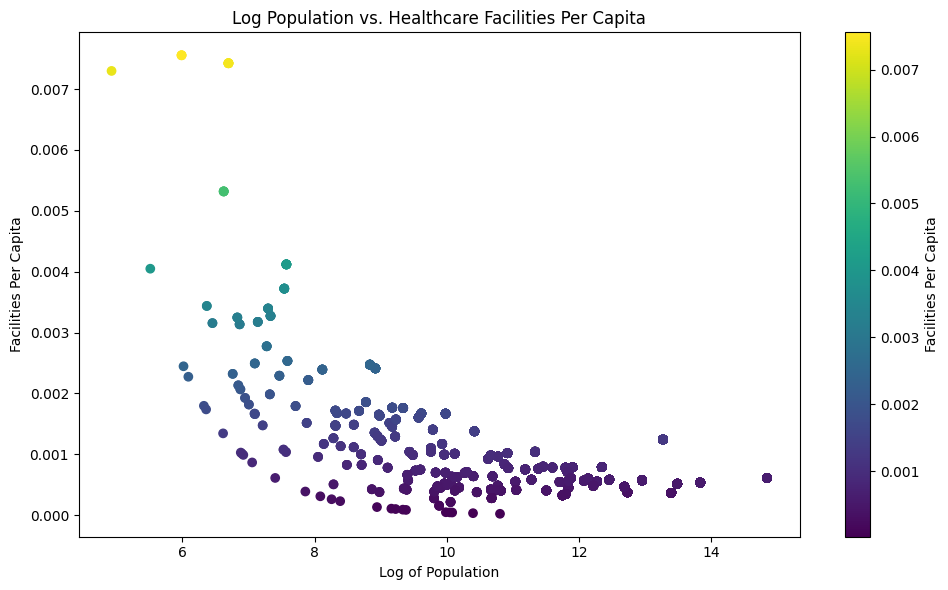

In [282]:
def plot_population_vs_facilities(merged_data):
    """Plot the log of population vs. healthcare facilities per capita.
    Args:
        merged_data (pd.DataFrame): The merged data with population and healthcare facilities.  
    Returns:
        None
    """
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(x=np.log1p(merged_data['Population, 2021']), y='Facilities_Per_Capita', c='Facilities_Per_Capita', cmap='viridis', data=merged_data)
    plt.colorbar(scatter, label='Facilities Per Capita')
    plt.title('Log Population vs. Healthcare Facilities Per Capita')
    plt.xlabel('Log of Population')
    plt.ylabel('Facilities Per Capita')
    plt.tight_layout()
    plt.savefig('datasets/scatter_population_vs_facilities_per_capita.png', dpi=300, bbox_inches='tight')
    plt.show() 

plot_population_vs_facilities(merged_data)

##### Analysis: 
- We can see a fairly clear trend showing that as the population increases, the frequency of facilities per capita decreases, with the exception of a few outliers.

### Scatter Plot of Population vs. Facilities Per Capita


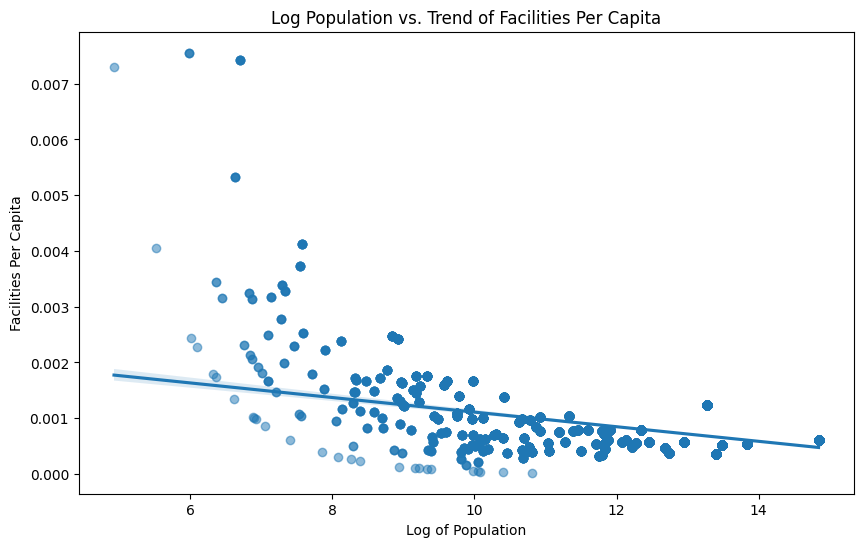

In [283]:
def plot_scatter_trend(merged_data):
    """Plot a scatter plot of log population vs. trend of facilities per capita.
    
    Args:
        merged_data (pd.DataFrame): The merged data containing population and facilities per capita.
    """
    plt.figure(figsize=(10, 6))
    sns.regplot(x=np.log1p(merged_data['Population, 2021']), y='Facilities_Per_Capita', data=merged_data, scatter_kws={'alpha':0.5})
    plt.title('Log Population vs. Trend of Facilities Per Capita')
    plt.xlabel('Log of Population')
    plt.ylabel('Facilities Per Capita')
    plt.savefig('datasets/scatter_trend_facilities_per_capita.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_scatter_trend(merged_data)

##### Analysis: 
- This is a a secondary graph with the addition of the line of best fit for ease of visualization. This graph corelates to the relation described in the previous scatter graph.

### Boxplot of Healthcare Facilities Per Capita
*Plot a boxplot of the 'Facilities_Per_Capita' column in the merged data.
highlighting the distribution and identifying any outliers.*


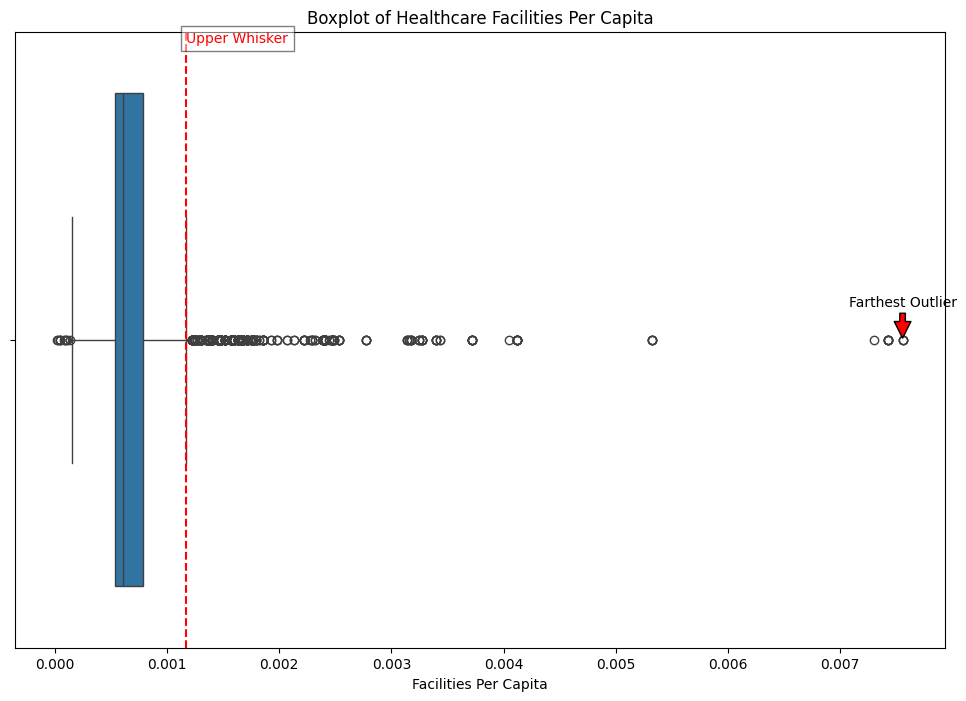

In [284]:
def plot_facilities_boxplot(merged_data):
    """Plot a boxplot of the 'Facilities_Per_Capita' column in the merged data.
    Also, identify the upper whisker and the farthest outlier, if any.
    
    Args:
    merged_data (DataFrame): The merged data containing the 'Facilities_Per_Capita' column.
    
    Returns:
    None
    """
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Facilities_Per_Capita', data=merged_data)
    plt.title('Boxplot of Healthcare Facilities Per Capita')
    plt.xlabel('Facilities Per Capita')

    # Calculate the upper whisker
    Q1 = merged_data['Facilities_Per_Capita'].quantile(0.25)
    Q3 = merged_data['Facilities_Per_Capita'].quantile(0.75)
    IQR = Q3 - Q1
    upper_whisker = Q3 + 1.5 * IQR

    # Draw upper whisker line
    plt.axvline(x=upper_whisker, color='r', linestyle='--')
    plt.text(upper_whisker, plt.ylim()[1], 'Upper Whisker', color='r', ha='left', va='top', 
             bbox=dict(facecolor='white', alpha=0.5))
    # Identify and annotate the farthest outlier, if any
    outliers = merged_data[merged_data['Facilities_Per_Capita'] > upper_whisker]['Facilities_Per_Capita']
    if not outliers.empty:
        farthest_outlier_value = outliers.max()
        plt.annotate('Farthest Outlier', xy=(farthest_outlier_value, 0), xytext=(farthest_outlier_value, -0.05),
                     arrowprops=dict(facecolor='red', shrink=0.05), ha='center', va='bottom')
    plt.show()

plot_facilities_boxplot(merged_data)

##### Analysis:
- Most regions have facilities per capita values within a relatively tight interquartile range, suggesting a degree of uniformity. However, the presence of outliers shows that some regions have significantly more facilities relative to their population, which can be considered over-served.


# Conclusion:

### Research Question: How does healthcare accessibility vary across different regions in Ontario?

Key findings indicate that densely populated areas, particularly major cities like Toronto and Ottawa, exhibit lower healthcare facilities per capita, whereas rural areas such as Killarney and Gore Bay show higher facilities per capita. This trend suggests a potential disparity in healthcare access, where urban populations may face greater challenges in accessing healthcare services compared to their rural counterparts.




Through various visualisations—including bar charts, scatter plots, and choropleth maps—the project effectively illustrated the geographic and demographic disparities in healthcare facility distribution. These visualisations clarified the relationship between population density and healthcare facility availability, with urban centres showing marked underrepresentation in healthcare provisioning relative to population size.
- For instance, the scatter plot of population versus facilities per capita clearly shows a decline in facilities per capita with increasing population, emphasising the strain on healthcare resources in urban settings




The use of data processing and geospatial analysis techniques in this project did not just map the current landscape of healthcare accessibility; it also provided a foundational tool for predictive analytics and strategic planning. By identifying areas with the highest and lowest facilities per capita, the project informs us on potential policy interventions and resource allocation to areas most in need.




In summary, while Ontario possesses a comprehensive healthcare infrastructure, there exists a clear disparity in accessibility across the province. This project shows the need for focused policy interventions that consider both demographic and geographic data to ensure equitable healthcare access across all regions in Ontario. The findings from this project could serve as benchmarks for similar analyses elsewhere, potentially guiding broader healthcare policy decisions and resource planning at a national level.